In [22]:
from pymatgen.ext.matproj import MPRester
from Bio.Seq import Seq
from collections import Counter
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import requests
import io

In [6]:
MAPI_KEY = "xjyJ6dHlCFb32OGypmupb14UheNyuMeP" 

material_name = "MnFe2O4"

structure = None
with MPRester(MAPI_KEY) as m:
    entries = m.get_entries(material_name)
    if entries:
        structure = entries[0].structure

if structure:
    print(f"\nСостав материала ({material_name}):")
    composition = structure.composition
    print(f"Химическая формула: {composition.reduced_formula}")
    print("Элементы и их количества:")
    for element, amount in composition.items():
        print(f"  {element.symbol}: {amount}")

    print("\nПараметры кристаллической решётки:")
    lattice = structure.lattice
    print(f"  Параметры (a, b, c): {lattice.abc}")
    print(f"  Углы (alpha, beta, gamma) в градусах: {lattice.angles}")
    print(f"  Объем ячейки: {lattice.volume:.3f} Å³")

    density = structure.density
    print(f"\nПлотность материала: {density:.3f} г/см³")
else:
    print("\nНе удалось продолжить анализ, так как структура не была загружена.")


Состав материала (MnFe2O4):
Химическая формула: Mn(FeO2)2
Элементы и их количества:
  Mn: 2.0
  Fe: 4.0
  O: 8.0

Параметры кристаллической решётки:
  Параметры (a, b, c): (6.053631465052196, 6.070382773765836, 6.089535049615036)
  Углы (alpha, beta, gamma) в градусах: (59.33925994022594, 59.573196887841874, 60.31516039578889)
  Объем ячейки: 157.284 Å³

Плотность материала: 4.870 г/см³


In [11]:
def calculate_gc_content(sequence):
    gc_count = sequence.count('G') + sequence.count('C')
    total_bases = len(sequence)
    if total_bases == 0:
        return 0.0
    return (gc_count / total_bases) * 100

print("Часть 2: Последовательности ДНК/РНК\n")

dna_sequence_1_str = "ATGCGTACGTAGCTAGCTAGCATGCATGCATGCA"
dna_sequence_1 = Seq(dna_sequence_1_str)
print(f"Последовательность ДНК 1: {dna_sequence_1}")

dna_sequence_2_str = "GATTACAATGCATGCTAGCATGCATGCATGCATGCATGCA"
dna_sequence_2 = Seq(dna_sequence_2_str)
print(f"Последовательность ДНК 2: {dna_sequence_2}")

dna_sequences = {
    "Gene_A_Fragment": dna_sequence_1,
    "Gene_B_Fragment": dna_sequence_2
}

for name, dna_seq_obj in dna_sequences.items():
    print(f"\nАнализируем: {name}")
    print(f"Исходная ДНК последовательность: {dna_seq_obj}")

    gc_percent = calculate_gc_content(str(dna_seq_obj).upper())
    print(f"GC-состав: {gc_percent:.2f}%")

    reverse_complement = dna_seq_obj.reverse_complement()
    print(f"Обратная комплементарная последовательность: {reverse_complement}")

    rna_sequence = dna_seq_obj.transcribe()
    print(f"Транскрибированная РНК последовательность: {rna_sequence}")

Часть 2: Последовательности ДНК/РНК

Последовательность ДНК 1: ATGCGTACGTAGCTAGCTAGCATGCATGCATGCA
Последовательность ДНК 2: GATTACAATGCATGCTAGCATGCATGCATGCATGCATGCA

Анализируем: Gene_A_Fragment
Исходная ДНК последовательность: ATGCGTACGTAGCTAGCTAGCATGCATGCATGCA
GC-состав: 50.00%
Обратная комплементарная последовательность: TGCATGCATGCATGCTAGCTAGCTACGTACGCAT
Транскрибированная РНК последовательность: AUGCGUACGUAGCUAGCUAGCAUGCAUGCAUGCA

Анализируем: Gene_B_Fragment
Исходная ДНК последовательность: GATTACAATGCATGCTAGCATGCATGCATGCATGCATGCA
GC-состав: 45.00%
Обратная комплементарная последовательность: TGCATGCATGCATGCATGCATGCTAGCATGCATTGTAATC
Транскрибированная РНК последовательность: GAUUACAAUGCAUGCUAGCAUGCAUGCAUGCAUGCAUGCA


In [ ]:
print("Часть 3: Белки (получение последовательности по UniProt ID через REST API)\n")

# 1. Выбрать белок альфа Амилаза по названию или UniProt ID и получить его последовательность аминокислот.
# Мы будем использовать UniProt ID для надежности.
uniprot_id = "P00790" # Используем тот же ID, но с другим методом загрузки

print(f"Пытаемся получить последовательность для белка с UniProt ID: {uniprot_id}...")

sequence = None
protein_name = "Неизвестный белок"

try:
    # URL для получения записи в формате FASTA из UniProt REST API
    # https://rest.uniprot.org/uniprotkb/{ID}.fasta
    fasta_url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}.fasta"

    print(f"Отправляем запрос к UniProt REST API: {fasta_url}")
    response = requests.get(fasta_url)
    response.raise_for_status() # Проверяем на ошибки HTTP

    # UniProt возвращает FASTA-файл. Используем SeqIO для его парсинга.
    # io.StringIO позволяет Biopython читать строку как файл.
    fasta_string_data = io.StringIO(response.text)
    
    # SeqIO.read ожидает, что в "файле" будет только одна запись FASTA
    record = SeqIO.read(fasta_string_data, "fasta")
    
    sequence = str(record.seq) # Последовательность как строка
    # Имя белка можно попытаться извлечь из заголовка FASTA записи,
    # но оно не всегда так же богато, как из SwissProt записи.
    # Например, из ">sp|P00790|AMY_BACAM Alpha-amylase 1 OS=Bacillus amyloliquefaciens OX=1390 GN=amyE PE=1 SV=1"
    parts = record.description.split(' ')
    if len(parts) > 2:
        protein_name = ' '.join(parts[2:]) # Берем все после ID и Accession как название
    else:
        protein_name = record.description # Если не удается, берем все описание

    print(f"Последовательность для '{protein_name}' (ID: {uniprot_id}) успешно получена:")
    print(sequence[:100] + "..." if len(sequence) > 100 else sequence) # Выводим первые 100 символов или всю
    print(f"Длина последовательности: {len(sequence)} аминокислот.")

except requests.exceptions.RequestException as e:
    print(f"Ошибка при запросе к UniProt REST API: {e}")
    print("Возможно, проблемы с интернетом или UniProt REST API недоступен.")
except Exception as e:
    print(f"Произошла непредвиденная ошибка: {e}")
    print("Убедитесь, что UniProt ID верен и формат ответа ожидаем.")

if sequence:
    # 2. Вычислить физико-химические дескрипторы белка
    print("\n--- Физико-химические дескрипторы белка ---")

    # Создаем объект ProteinAnalysis из последовательности
    analyzed_seq = ProteinAnalysis(sequence)

    # Состав аминокислот
    amino_acids_composition = analyzed_seq.get_amino_acids_percent()
    print("\nСостав аминокислот (процентное содержание):")
    sorted_composition = sorted(amino_acids_composition.items(), key=lambda item: item[1], reverse=True)
    for aa, percent in sorted_composition:
        print(f"  {aa}: {percent * 100:.2f}%")

    # Частоты дипептидов
    print("\nЧастоты дипептидов (топ-10 наиболее частых):")
    dipeptide_composition = analyzed_seq.get_dipeptide_composition()
    sorted_dipeptides = sorted(dipeptide_composition.items(), key=lambda item: item[1], reverse=True)
    for dipeptide, count in sorted_dipeptides[:10]:
        print(f"  {dipeptide}: {count}")

    # Дополнительные дескрипторы (примеры)
    print("\nДополнительные дескрипторы:")
    print(f"Молекулярная масса: {analyzed_seq.molecular_weight():.2f}")
    print(f"Изоэлектрическая точка (pI): {analyzed_seq.isoelectric_point():.2f}")
    print(f"Индекс нестабильности (низкое значение = стабильный): {analyzed_seq.instability_index():.2f}")
    print(f"Алифатический индекс: {analyzed_seq.aliphatic_index():.2f}")
    print(f"Заряд при pH 7.0: {analyzed_seq.charge_at_pH(7.0):.2f}")

else:
    print("\nНе удалось продолжить анализ, так как последовательность белка не была получена.")

In [21]:
def fetch_protein_sequence(uniprot_id):
    url = f"https://www.uniprot.org/uniprot/{uniprot_id}.fasta"
    response = requests.get(url)
    if response.status_code == 200:
        sequence = ''.join(response.text.split('\n')[1:])
        return sequence
    else:
        raise ValueError("Ошибка при получении последовательности")

uniprot_id = "P00690"
sequence = fetch_protein_sequence(uniprot_id)
print(f"Последовательность белка {uniprot_id}:\n{sequence}")

Последовательность белка P00690:
MKLFLLLSAFGFCWAQYAPQTQSGRTSIVHLFEWRWVDIALECERYLGPKGFGGVQVSPPNENIVVTNPSRPWWERYQPVSYKLCTRSGNENEFRDMVTRCNNVGVRIYVDAVINHMCGSGAAAGTGTTCGSYCNPGNREFPAVPYSAWDFNDGKCKTASGGIESYNDPYQVRDCQLVGLLDLALEKDYVRSMIADYLNKLIDIGVAGFRIDASKHMWPGDIKAVLDKLHNLNTNWFPAGSRPFIFQEVIDLGGEAIQSSEYFGNGRVTEFKYGAKLGTVVRKWSGEKMSYLKNWGEGWGFMPSDRALVFVDNHDNQRGHGAGGASILTFWDARLYKVAVGFMLAHPYGFTRVMSSYRWARNFVNGQDVNDWIGPPNNNGVIKEVTINADTTCGNDWVCEHRWRQIRNMVWFRNVVDGQPFANWWANGSNQVAFGRGNRGFIVFNNDDWQLSSTLQTGLPGGTYCDVISGDKVGNSCTGIKVYVSSDGTAQFSISNSAEDPFIAIHAESKL


In [23]:
aa_composition = Counter(sequence)
print("Состав аминокислот:")
for aa, count in aa_composition.items():
    print(f"{aa}: {count}")

Состав аминокислот:
M: 10
K: 20
L: 29
F: 27
S: 34
A: 34
G: 54
C: 13
W: 20
Q: 17
Y: 19
P: 21
T: 22
R: 28
I: 25
V: 41
H: 9
E: 20
D: 30
N: 38


In [24]:
dipeptides = [sequence[i:i+2] for i in range(len(sequence)-1)]
dipeptide_freq = Counter(dipeptides)

print("Частоты дипептидов:")
for dipeptide, count in dipeptide_freq.most_common():  # Сортировка по убыванию
    print(f"{dipeptide}: {count}")

Частоты дипептидов:
GF: 7
KL: 6
SG: 6
GN: 6
GG: 5
SY: 5
GT: 5
ND: 5
FG: 4
VD: 4
GV: 4
VT: 4
NN: 4
VG: 4
VR: 4
AV: 4
VI: 4
GS: 4
GA: 4
AG: 4
SS: 4
NG: 4
LL: 3
SA: 3
WA: 3
GR: 3
SI: 3
IV: 3
RW: 3
DI: 3
IA: 3
AL: 3
YL: 3
LG: 3
QV: 3
VS: 3
NE: 3
VV: 3
TR: 3
EF: 3
FR: 3
YV: 3
DA: 3
CG: 3
TG: 3
PG: 3
PY: 3
DG: 3
AS: 3
ID: 3
VA: 3
IK: 3
NW: 3
PF: 3
FI: 3
GE: 3
RG: 3
KV: 3
RN: 3
DW: 3
LF: 2
LS: 2
AF: 2
AQ: 2
QT: 2
QS: 2
WR: 2
WV: 2
LE: 2
CE: 2
ER: 2
RY: 2
GP: 2
PP: 2
PN: 2
EN: 2
TN: 2
NP: 2
PS: 2
SR: 2
RP: 2
WW: 2
YQ: 2
QP: 2
YK: 2
CT: 2
RS: 2
RD: 2
MV: 2
CN: 2
NV: 2
RI: 2
IN: 2
NH: 2
HM: 2
AA: 2
TT: 2
TC: 2
YC: 2
NR: 2
FP: 2
PA: 2
WD: 2
FN: 2
TA: 2
GI: 2
ES: 2
DP: 2
QL: 2
LV: 2
GL: 2
LD: 2
DL: 2
LA: 2
EK: 2
DY: 2
AD: 2
LN: 2
IG: 2
SK: 2
GD: 2
DK: 2
WF: 2
EV: 2
AI: 2
RV: 2
YG: 2
MS: 2
WG: 2
FM: 2
SD: 2
VF: 2
FV: 2
DN: 2
NQ: 2
AR: 2
VN: 2
GQ: 2
DV: 2
AN: 2
SN: 2
IS: 2
NS: 2
AE: 2
MK: 1
FL: 1
FC: 1
CW: 1
QY: 1
YA: 1
AP: 1
PQ: 1
TQ: 1
RT: 1
TS: 1
VH: 1
HL: 1
FE: 1
EW: 1
EC: 1
PK: 1
KG: 1
VQ: 1
SP

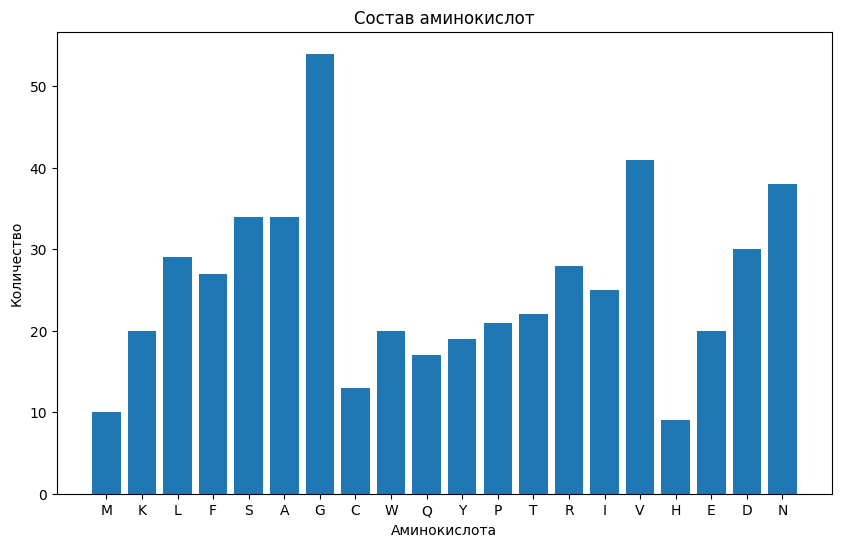

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(aa_composition.keys(), aa_composition.values())
plt.title("Состав аминокислот")
plt.xlabel("Аминокислота")
plt.ylabel("Количество")
plt.show()

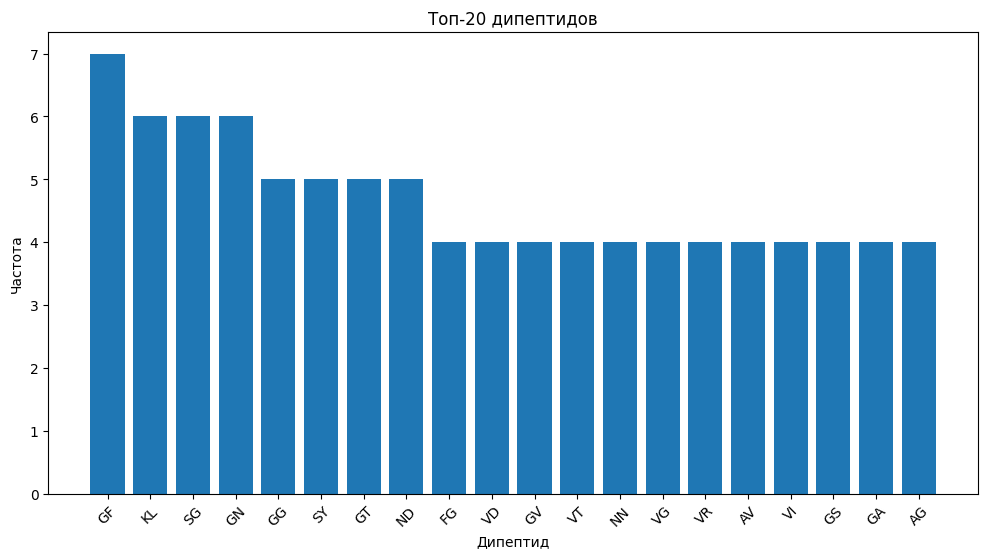

In [26]:
plt.figure(figsize=(12, 6))
top_dipeptides = dipeptide_freq.most_common(20)
plt.bar([d[0] for d in top_dipeptides], [d[1] for d in top_dipeptides])
plt.title("Топ-20 дипептидов")
plt.xlabel("Дипептид")
plt.ylabel("Частота")
plt.xticks(rotation=45)
plt.show()